In [ ]:
!pip install gymnasium
!pip install "gymnasium[atari,accept-rom-license]"
!pip install "gymnasium[accept-rom-license
!apt-get install -y swig
!pip install grid2op
!pip install lightsim2grid

/bin/bash: -c: line 1: unexpected EOF while looking for matching `"'
/bin/bash: -c: line 2: syntax error: unexpected end of file
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


Observation space defined with 159 features.
Action space defined with 35 discrete actions corresponding to lines, substations, and do nothing.
Observation space defined with 159 features.
Action space defined with 35 discrete actions corresponding to lines, substations, and do nothing.
Episode: 1, Total Reward: 5.367502391338348, Steps: 22
Episode: 2, Total Reward: 0.05397897958755493, Steps: 3
Episode: 3, Total Reward: 17.311617493629456, Steps: 55
Episode: 4, Total Reward: 36.79199132323265, Steps: 100
Episode: 5, Total Reward: 35.46590131521225, Steps: 100
Episode: 6, Total Reward: 37.539296209812164, Steps: 100
Episode: 7, Total Reward: 36.52537524700165, Steps: 100
Episode: 8, Total Reward: 35.360458582639694, Steps: 100
Episode: 9, Total Reward: 36.14943642914295, Steps: 100
Episode: 10, Total Reward: 36.196120887994766, Steps: 100
Episode: 11, Total Reward: 37.48403298854828, Steps: 100
Episode: 12, Total Reward: 37.20553860068321, Steps: 100
Episode: 13, Total Reward: 38.18654

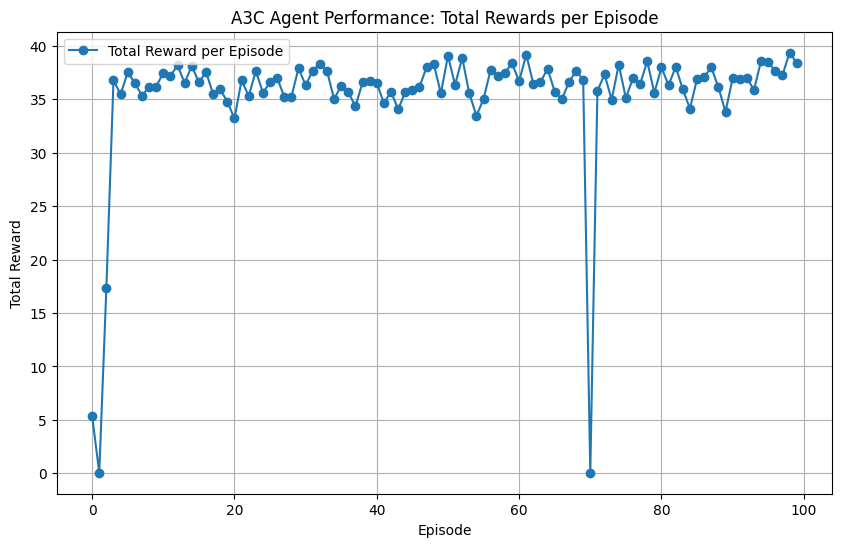

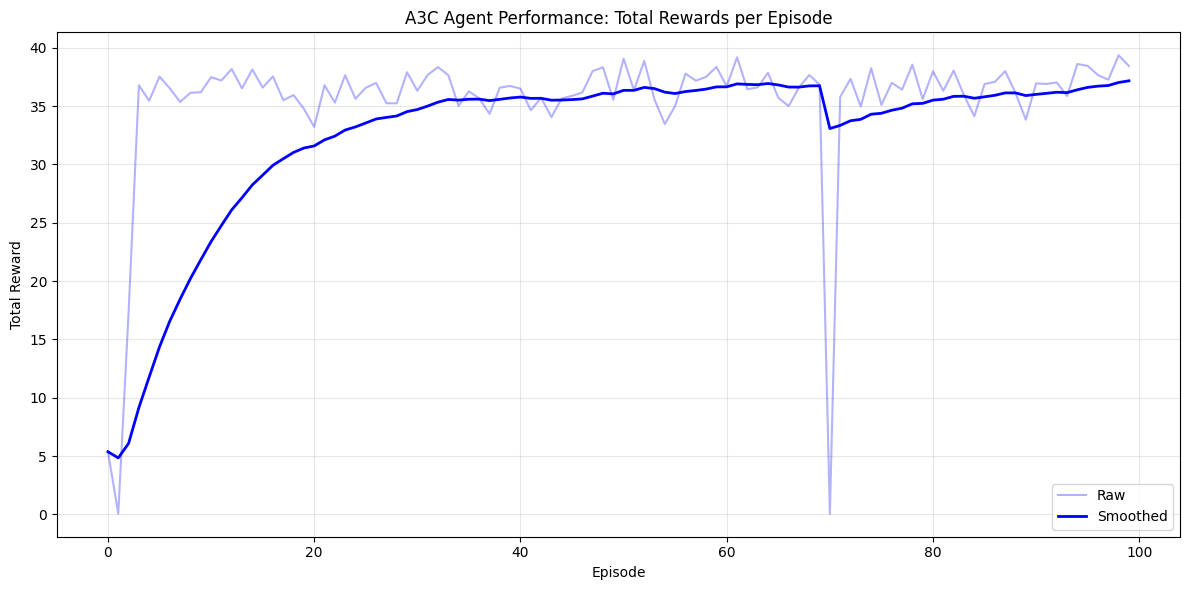

In [ ]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import threading
import multiprocessing
import matplotlib.pyplot as plt

import grid2op
from grid2op import gym_compat
from grid2op.Parameters import Parameters
from grid2op.Action import PlayableAction
from grid2op.Observation import CompleteObservation
from grid2op.Reward import L2RPNReward, N1Reward, CombinedScaledReward

from lightsim2grid import LightSimBackend


class Gym2OpEnv(gym.Env):
    def __init__(self):
        super().__init__()

        self._backend = LightSimBackend()
        self._env_name = "l2rpn_case14_sandbox"

        action_class = PlayableAction
        observation_class = CompleteObservation
        reward_class = CombinedScaledReward

        p = Parameters()
        p.MAX_SUB_CHANGED = 4
        p.MAX_LINE_STATUS_CHANGED = 4

        self._g2op_env = grid2op.make(
            self._env_name, backend=self._backend, test=False,
            action_class=action_class, observation_class=observation_class,
            reward_class=reward_class, param=p
        )

        cr = self._g2op_env.get_reward_instance()
        cr.addReward("N1", N1Reward(), 1.0)
        cr.addReward("L2RPN", L2RPNReward(), 1.0)
        cr.initialize(self._g2op_env)

        self.setup_observations()
        self.setup_actions()

    def setup_observations(self):
        obs = self._g2op_env.reset()

        self.obs_components = [
          ("rho", obs.rho),
          ("line_status", obs.line_status),
          ("actual_dispatch", obs.actual_dispatch),
          ("load_p", obs.load_p),
          ("load_q", obs.load_q),
          ("topo_vect", obs.topo_vect),
          ("time_before_cooldown_line", obs.time_before_cooldown_line),
          ("time_before_cooldown_sub", obs.time_before_cooldown_sub),
        ]

        total_size = sum(component[1].size for component in self.obs_components)

        self.observation_space = gym.spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(total_size,),
            dtype=np.float32
        )

        print(f"Observation space defined with {total_size} features.")

    def _format_observation(self, obs):
        return np.concatenate([obs.__dict__[comp[0]].flatten() for comp in self.obs_components]).astype(np.float32)

    def setup_actions(self):
        num_substations = self._g2op_env.n_sub
        num_lines = self._g2op_env.n_line

        self.action_space = gym.spaces.Discrete(num_lines + num_substations + 1)
        print(f"Action space defined with {self.action_space.n} discrete actions corresponding to lines, substations, and do nothing.")

    def reset(self, seed=None):
        g2op_obs = self._g2op_env.reset(seed=seed)
        obs = self._format_observation(g2op_obs)
        return obs, {}

    def step(self, action):
        g2op_action = self._convert_action(action)
        g2op_obs, reward, done, info = self._g2op_env.step(g2op_action)
        obs = self._format_observation(g2op_obs)
        truncated = False
        return obs, reward, done, truncated, info

    def _convert_action(self, gym_action):
        if gym_action == 0:  # Do nothing
            return self._g2op_env.action_space()
        else:
            line_id = (gym_action - 1) // 2
            new_status = 1 if (gym_action - 1) % 2 == 0 else -1
            return self._g2op_env.action_space({"set_line_status": [(line_id, new_status)]})

    def render(self):
        return self._g2op_env.render()

# A3C Network
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(ActorCritic, self).__init__()
        self.fc1 = nn.Linear(num_inputs, 128)
        self.fc2 = nn.Linear(128, 256)
        self.actor = nn.Linear(256, num_actions)
        self.critic = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        policy = F.softmax(self.actor(x), dim=-1)
        value = self.critic(x)
        return policy, value

# Worker for A3C
class Worker(threading.Thread):
    def __init__(self, global_model, optimizer, global_episode, global_step, max_steps, episode_rewards):
        super(Worker, self).__init__()
        self.env = Gym2OpEnv()
        self.local_model = ActorCritic(self.env.observation_space.shape[0], self.env.action_space.n)
        self.global_model = global_model
        self.optimizer = optimizer
        self.global_episode = global_episode
        self.global_step = global_step
        self.max_steps = max_steps
        self.episode_rewards = episode_rewards

    def run(self):
        while True:
            with self.global_episode.get_lock():
                if self.global_episode.value >= 100:  # Check if the limit is reached
                    break
                self.global_episode.value += 1
                episode_num = self.global_episode.value

            state, _ = self.env.reset()
            self.local_model.load_state_dict(self.global_model.state_dict())

            done = False
            total_reward = 0
            step = 0

            while not done and step < self.max_steps:
                policy, value = self.local_model(torch.FloatTensor(state))
                action_dist = Categorical(policy)
                action = action_dist.sample()

                next_state, reward, done, truncated, info = self.env.step(action.item())
                done = done or truncated

                total_reward += reward
                step += 1

                self.update_global(state, action, reward, next_state, done)
                state = next_state

            self.episode_rewards.append(total_reward)
            print(f"Episode: {episode_num}, Total Reward: {total_reward}, Steps: {step}")

    def update_global(self, state, action, reward, next_state, done):
        self.optimizer.zero_grad()
        policy, value = self.local_model(torch.FloatTensor(state))
        _, next_value = self.local_model(torch.FloatTensor(next_state))
        target = reward + 0.99 * next_value * (1 - int(done))
        advantage = target - value
        actor_loss = -torch.log(policy[action]) * advantage.detach()
        critic_loss = advantage.pow(2)
        loss = actor_loss + 0.5 * critic_loss
        loss.backward()

        for local_param, global_param in zip(self.local_model.parameters(), self.global_model.parameters()):
            if global_param.grad is not None:
                global_param.grad += local_param.grad
            else:
                global_param.grad = local_param.grad.clone()

        self.optimizer.step()
        with self.global_step.get_lock():
            self.global_step.value += 1

def plot_rewards(episode_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(episode_rewards, label="Total Reward per Episode", marker='o', linestyle='-')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('A3C Agent Performance: Total Rewards per Episode')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_a3c_performance(episode_rewards, smooth_factor=0.1):
    plt.figure(figsize=(12, 6))

    # Plot raw data
    episodes = range(len(episode_rewards))
    plt.plot(episodes, episode_rewards, alpha=0.3, color='blue', label='Raw')

    # Plot smoothed data
    smoothed_rewards = []
    for i, reward in enumerate(episode_rewards):
        if i == 0:
            smoothed_rewards.append(reward)
        else:
            previous = smoothed_rewards[-1]
            smoothed_rewards.append(previous * (1 - smooth_factor) + reward * smooth_factor)

    plt.plot(episodes, smoothed_rewards, linewidth=2, color='blue', label='Smoothed')

    plt.title('A3C Agent Performance: Total Rewards per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('a3c_performance.png')
    plt.show()

def evaluate_model(env, model, num_episodes=100):
    for episode in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        step = 0

        while not done and step < 100:
            policy, _ = model(torch.FloatTensor(state))
            action = torch.argmax(policy).item()
            next_state, reward, done, truncated, info = env.step(action)
            done = done or truncated
            total_reward += reward
            state = state
            step += 1

        print(f"Evaluation Episode {episode + 1}: Total Reward = {total_reward}, Steps = {step}")

def main():
    env = Gym2OpEnv()
    global_model = ActorCritic(env.observation_space.shape[0], env.action_space.n)
    global_model.share_memory()

    optimizer = optim.Adam(global_model.parameters(), lr=0.0002)
    global_episode = multiprocessing.Value('i', 0)
    global_step = multiprocessing.Value('i', 0)
    episode_rewards = multiprocessing.Manager().list()

    num_workers = max(1, multiprocessing.cpu_count() // 2)
    workers = [Worker(global_model, optimizer, global_episode, global_step, max_steps=100, episode_rewards=episode_rewards) for _ in range(num_workers)]

    [w.start() for w in workers]
    [w.join() for w in workers]

    evaluate_model(env, global_model)
    plot_rewards(episode_rewards)
    plot_a3c_performance(episode_rewards)

if __name__ == "__main__":
    main()